In [1]:
import random
import sys
import os
sys.path.append(os.getcwd())
from visualizer.main import Visualizer 
from algorithms.quadtree import QuadTree, Rectangle, Point
from algorithms.quadtree.quadtree_visualization import quadtree_vis


from algorithms.kd_tree.kd_class import *
from algorithms.kd_tree.kd_build_visualization import *
from algorithms.kd_tree.kd_query_visualization import * 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import random

In [2]:
all_points = []
for _ in range(50):
    p = Point(random.uniform(0, 800), random.uniform(0, 800))
    #qt.insert(p)
    all_points.append(p)

boundary = Rectangle(400, 400, 400, 400)
k = 4
vis = quadtree_vis(all_points, boundary, k)

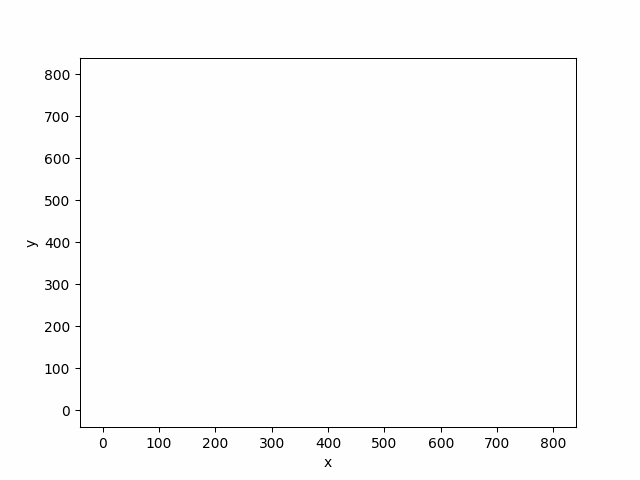

In [3]:
vis.show_gif(interval=200)


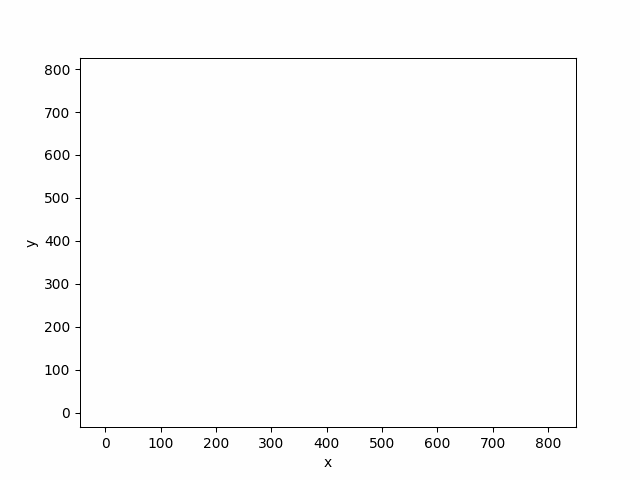

In [4]:
points = [(random.uniform(0, 800), random.uniform(0, 800)) for _ in range(100)]
vis_kd = kd_build_visualization(points)
vis_kd.show_gif()

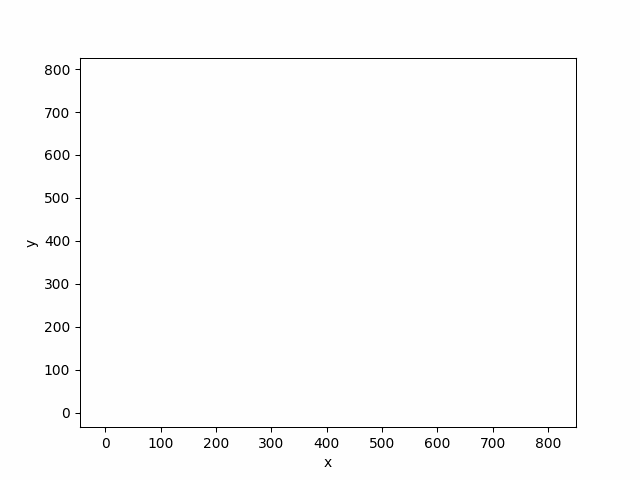

In [5]:
tree = KDTree(points)
query_box = (200, 600, 200, 500) # x_min, x_max, y_min, y_max
vis_kd2 = visualize_kdtree_query(tree, points, query_box)
vis_kd2.show_gif(interval=150)